In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load RFM data
rfm = pd.read_csv("../data/rfm_table.csv")

# Preview
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,77183.60
1,12347,3,7,4310.00
2,12348,76,4,1797.24
3,12349,19,1,1757.55
4,12350,311,1,334.40


# Quick Data Inspection

In [2]:
rfm.describe()

,CustomerID,recency,frequency,monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,93.059474,4.272015,2054.266460
std,1721.808492,100.012264,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.750000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


# Prepare Data for Clustering

In [3]:
# Select only RFM features
features = rfm[['recency', 'frequency', 'monetary']]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features[:5]

array([[ 2.32938811, -0.4250965 ,  8.35866818],
       [-0.90058811,  0.3544168 ,  0.25096626],
       [-0.17059349, -0.03533985, -0.02859601],
       [-0.74058929, -0.4250965 , -0.0330118 ],
       [ 2.17938921, -0.4250965 , -0.19134727]])

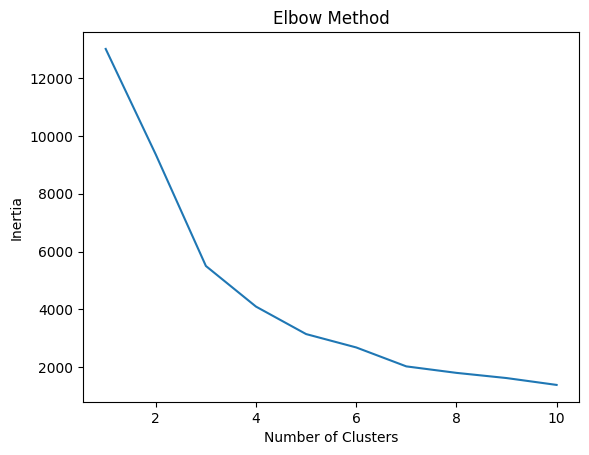

In [4]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Log transform to reduce skewness

In [ ]:

rfm_log = rfm.copy()

rfm_log['recency'] = np.log1p(rfm_log['recency'])
rfm_log['frequency'] = np.log1p(rfm_log['frequency'])
rfm_log['monetary'] = np.log1p(rfm_log['monetary'])

rfm_log.describe()

,CustomerID,recency,frequency,monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,3.857192,1.345582,6.593627
std,1721.808492,1.307060,0.683104,1.257578
min,12346.000000,0.693147,0.693147,1.558145
25%,13813.250000,2.944439,0.693147,5.731446
50%,15299.500000,3.951244,1.098612,6.515431
75%,16778.750000,4.968071,1.791759,7.416222
max,18287.000000,5.926926,5.347108,12.543284


In [ ]:
features = rfm_log[['recency', 'frequency', 'monetary']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features[:5]

array([[ 1.47888429, -0.95521426,  3.70622476],
       [-1.89064214,  1.07442519,  1.41184341],
       [ 0.37233877,  0.38630445,  0.7164889 ],
       [-0.65915823, -0.95521426,  0.6987394 ],
       [ 1.4429545 , -0.95521426, -0.6189622 ]])

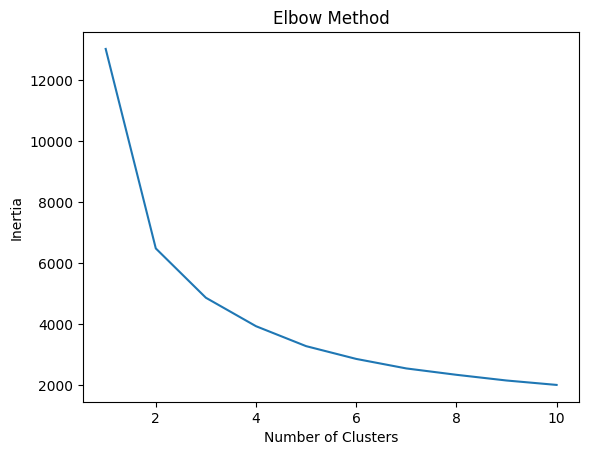

In [7]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [ ]:

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(scaled_features)

rfm.head()

,CustomerID,recency,frequency,monetary,cluster
0,12346,326,1,77183.60,1
1,12347,3,7,4310.00,3
2,12348,76,4,1797.24,1
3,12349,19,1,1757.55,0
4,12350,311,1,334.40,2


In [9]:
cluster_summary = rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'customer_count'})

cluster_summary

,recency,frequency,monetary,customer_count
cluster,,,,
0,23.123894,1.917035,488.220111,904
1,65.198980,4.193878,1831.410844,1176
2,192.979234,1.347826,362.298605,1541
3,12.179916,13.654114,8030.705188,717


In [10]:
def label_cluster(row):
    if row['cluster'] == 3:
        return 'VIP'
    elif row['cluster'] == 1:
        return 'Loyal'
    elif row['cluster'] == 0:
        return 'Promising'
    else:
        return 'At Risk'

rfm['segment'] = rfm.apply(label_cluster, axis=1)

rfm.head()

,CustomerID,recency,frequency,monetary,cluster,segment
0,12346,326,1,77183.60,1,Loyal
1,12347,3,7,4310.00,3,VIP
2,12348,76,4,1797.24,1,Loyal
3,12349,19,1,1757.55,0,Promising
4,12350,311,1,334.40,2,At Risk


In [11]:
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=False)
segment_revenue

segment
VIP          5758015.620
Loyal        2153739.153
At Risk       558302.151
Promising     441350.980
Name: monetary, dtype: float64

You have:

717 VIP customers

4,338 total customers

That’s about 16% of customers generating ~65% of revenue.

That’s a massive insight.

This is exactly what hiring managers want to see.

Not “I ran KMeans.”

But:

A small VIP segment drives the majority of revenue. Retention strategy for this group is critical.

In [12]:
total_revenue = rfm['monetary'].sum()

segment_summary = rfm.groupby('segment').agg({
    'CustomerID': 'count',
    'monetary': 'sum'
}).rename(columns={'CustomerID': 'customer_count'})

segment_summary['revenue_percentage'] = (
    segment_summary['monetary'] / total_revenue * 100
)

segment_summary.sort_values('monetary', ascending=False)

,customer_count,monetary,revenue_percentage
segment,,,
VIP,717,5758015.620,64.613983
Loyal,1176,2153739.153,24.168338
At Risk,1541,558302.151,6.265027
Promising,904,441350.980,4.952652


Now you’ve built something real.

Let’s read this like an executive would.

Executive Interpretation
VIP

717 customers (16%)

64.6% of total revenue

Small group. Massive impact.
These customers must be retained at all costs.
Personalized offers. Early access. Loyalty rewards.

Loyal

1,176 customers (27%)

24.2% of revenue

Stable mid-tier.
Upsell potential.
Convert some into VIP.

At Risk

1,541 customers (35%)

Only 6.2% of revenue

Largest group.
Low value right now.
Reactivation campaigns could bring incremental revenue.

Promising

904 customers (21%)

4.9% revenue

Recent but low spend.
Nurture them before they become At Risk.

This Is Portfolio Gold

You didn’t just cluster.

You:

Cleaned messy retail data

Engineered RFM features in SQL

Handled skew correctly

Applied ML

Interpreted business impact

Quantified revenue concentration

That’s strong.

Now next step is critical.

We need 2 things:

Visualization for GitHub

Export this labeled dataset for Power BI

In [13]:
rfm.to_csv("../data/rfm_segmented.csv", index=False)

# Revenue by Segment (Bar Chart)

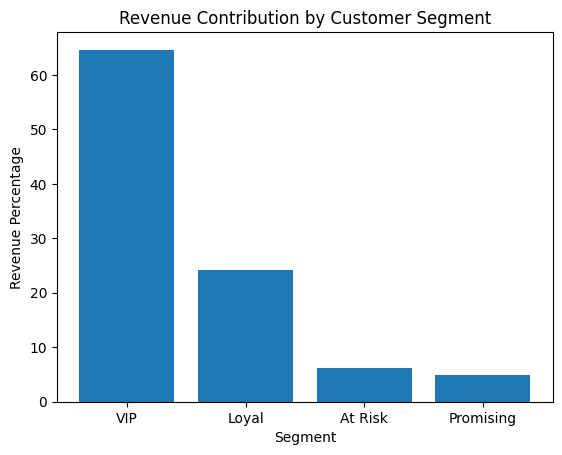

In [14]:
import matplotlib.pyplot as plt

segment_summary = rfm.groupby('segment').agg({
    'CustomerID': 'count',
    'monetary': 'sum'
}).rename(columns={'CustomerID': 'customer_count'})

segment_summary['revenue_percentage'] = (
    segment_summary['monetary'] / rfm['monetary'].sum() * 100
)

segment_summary = segment_summary.sort_values('revenue_percentage', ascending=False)

plt.figure()
plt.bar(segment_summary.index, segment_summary['revenue_percentage'])
plt.xlabel("Segment")
plt.ylabel("Revenue Percentage")
plt.title("Revenue Contribution by Customer Segment")
plt.show()

# Customer Distribution by Segment

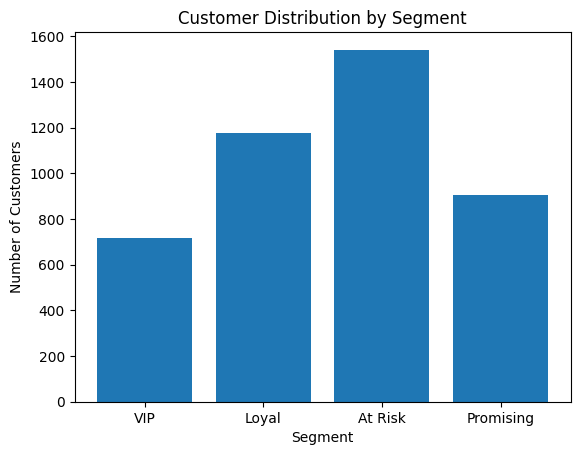

In [15]:
plt.figure()
plt.bar(segment_summary.index, segment_summary['customer_count'])
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution by Segment")
plt.show()

# Cluster Scatter Plot (2D Projection)

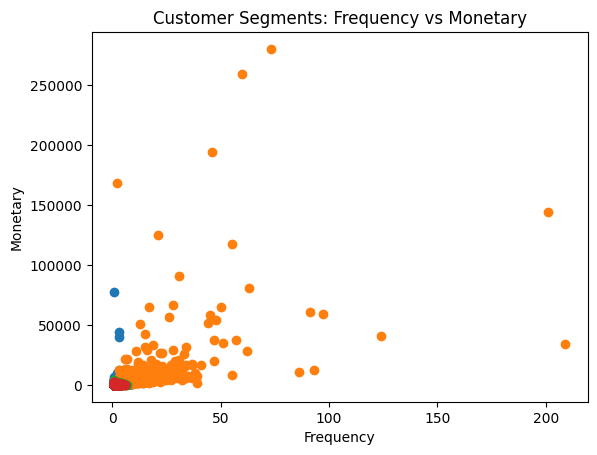

In [16]:
plt.figure()

for segment in rfm['segment'].unique():
    subset = rfm[rfm['segment'] == segment]
    plt.scatter(subset['frequency'], subset['monetary'])

plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("Customer Segments: Frequency vs Monetary")
plt.show()

# Observations:

Most customers are concentrated in low frequency + low monetary zone.

A small group extends far right and high up — those are your VIPs.

Heavy skew is visible (few extreme high spenders).

Clear density differences between segments.

That’s normal for retail data. Real-world data is messy. Clean separation is rare.

But here’s the important part:

Right now, the plot is visually messy for GitHub.

Too dense.
No legend.
Hard to distinguish segments.

# Make the Scatter Plot Cleaner

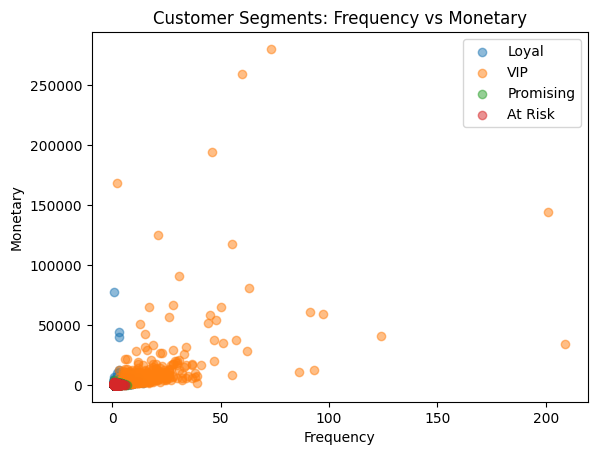

In [17]:
plt.figure()

for segment in rfm['segment'].unique():
    subset = rfm[rfm['segment'] == segment]
    plt.scatter(
        subset['frequency'],
        subset['monetary'],
        label=segment,
        alpha=0.5
    )

plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("Customer Segments: Frequency vs Monetary")
plt.legend()
plt.show()